In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Cài đặt 
!pip install xgboost
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1
import warnings
warnings.simplefilter('ignore', FutureWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
import pandas as pd

df01 = pd.read_csv('/kaggle/input/clean-aws-month/final_data/filled_data_april.csv')
df02 = pd.read_csv('/kaggle/input/clean-aws-month/final_data/filled_data_october.csv')

# Ghép 2 file lại với nhau
data_filled = pd.concat([df01, df02], ignore_index=True)

# 1. Xử lý dữ liệu bị thiếu

In [3]:
# df_cleaned = data.copy()
# df_cleaned = df_cleaned.drop(columns=['B04B', 'B05B', 'B06B', 'VSB', 'CIN'])

# df_cleaned = df_cleaned[~((df_cleaned['AWS'] == -np.inf) | (df_cleaned['AWS'].isnull()))]
# df_cleaned = df_cleaned[~((df_cleaned['SLHF'] == 9999) | (df_cleaned['SSHF'] == 9999))]

In [4]:
# data_filled = df_cleaned.fillna(df_cleaned.median(numeric_only=True))

# 2. Chia train test

In [5]:
def split_data_by_multiple_ranges(df, train_ranges):
    train_mask = False
    for start, end in train_ranges:
        train_mask |= (df['datetime'] >= start) & (df['datetime'] < end)
    train_df = df[train_mask]
    test_df = df[~train_mask]
    return train_df, test_df

def convert_rain_label(df):
    df['AWS'] = df['AWS'].apply(lambda x: 1 if x > 0 else 0)
    return df

# Gắn nhãn
df_all1 = convert_rain_label(data_filled)

# Chuyển datetime nếu chưa
df_all1['datetime'] = pd.to_datetime(df_all1['datetime'])

# Chọn các khoảng train: tháng 4/2019, 10/2019, 4/2020
train_ranges = [
    ("2019-04-01", "2019-04-30"),
    ("2019-10-01", "2019-10-31"),
    ("2020-04-01", "2020-04-30"),
]

# Tách train/test theo mốc trên
train_df, test_df = split_data_by_multiple_ranges(df_all1, train_ranges)

# Giữ lại chỉ test tháng 10/2020
test_df = test_df[
    (test_df['datetime'] >= "2020-10-01") & (test_df['datetime'] <= "2020-10-31")
]

# Kết quả
print(f"Train set: {train_df.shape}")
print(f"Test set (October 2020): {test_df.shape}")

Train set: (428242, 33)
Test set (October 2020): (207094, 33)


In [6]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

# 3. Chuẩn hóa

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 4. Chọn feature

In [8]:
top_features = ['B14B', 'I2B', 'TCLW', 'R500', 'R850', 'CAPE', 'U850', 'B10B', 'PEV', 'SLOR', 'R250', 'KX', 'V250', 'U250', 'TCWV']

In [9]:
# X_train_selected = X_train_scaled[top_features]
# X_test_selected = X_test_scaled[top_features]

In [10]:
#Performance evaluation
def print_scores(y_true, y_pred):
  print(classification_report(y_true, y_pred))

# 5. SCG

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [12]:
models_info = [
    ("Tháng 4 + 10", X_train_scaled, y_train, X_test_scaled, y_test),
]

### Chọn tất


=== Dataset: Tháng 4 + 10 ===
 hidden_dim=10  → val loss = 0.696859
 hidden_dim=20  → val loss = 0.682030
 hidden_dim=50  → val loss = 0.688931
 hidden_dim=100 → val loss = 0.694015
 hidden_dim=150 → val loss = 0.705080
 hidden_dim=17  → val loss = 0.697219
 hidden_dim=25  → val loss = 0.695556
 hidden_dim=34  → val loss = 0.692650
 hidden_dim=50  → val loss = 0.692332
 hidden_dim=68  → val loss = 0.695137
 hidden_dim=85  → val loss = 0.693351
⇒ Best hidden_dim = 20, validation loss = 0.682030
Test classification report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    159566
           1       0.23      1.00      0.37     47528

    accuracy                           0.23    207094
   macro avg       0.11      0.50      0.19    207094
weighted avg       0.05      0.23      0.09    207094

Test confusion matrix:
 [[     0 159566]
 [     0  47528]]


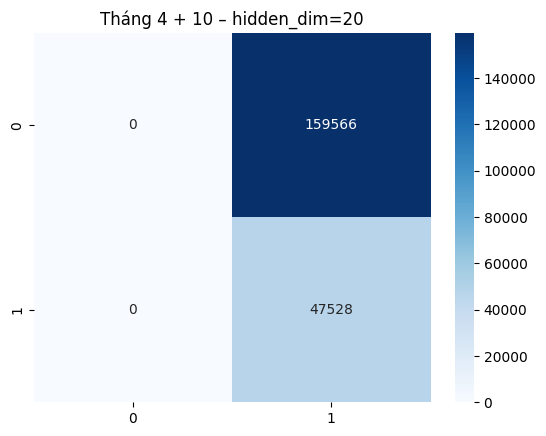

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# ——— Utility functions ———
def softmax(Z):
    # Ensure Z is a numpy array of shape (n_samples, n_classes)
    Z_arr = Z.values if hasattr(Z, "values") else np.array(Z)
    # 1) subtract the max for numerical stability
    #    max_per_row: shape (n_samples,)
    max_per_row = np.max(Z_arr, axis=1)
    #    reshape to (n_samples, 1) so broadcasting works
    max_per_row = max_per_row.reshape(-1, 1)
    # 2) exponentiate
    expZ = np.exp(Z_arr - max_per_row)
    # 3) sum per row, then reshape to (n_samples, 1)
    sum_per_row = np.sum(expZ, axis=1).reshape(-1, 1)
    # 4) divide
    return expZ / sum_per_row

def pack(W1, b1, W2, b2):
    """
    Flatten and concatenate parameters, handling pandas DataFrame/Series inputs.
    """
    # Convert DataFrame/Series to numpy arrays
    W1_arr = W1.values if isinstance(W1, pd.DataFrame) else np.array(W1)
    b1_arr = b1.values if isinstance(b1, (pd.Series, pd.DataFrame)) else np.array(b1)
    W2_arr = W2.values if isinstance(W2, pd.DataFrame) else np.array(W2)
    b2_arr = b2.values if isinstance(b2, (pd.Series, pd.DataFrame)) else np.array(b2)
    # Flatten and concatenate
    return np.hstack([
        W1_arr.ravel(),
        b1_arr.ravel(),
        W2_arr.ravel(),
        b2_arr.ravel()
    ])

def unpack(p, input_dim, hidden_dim, output_dim):
    idx = 0
    W1 = p[idx:idx + hidden_dim*input_dim].reshape(hidden_dim, input_dim)
    idx += hidden_dim*input_dim
    b1 = p[idx:idx + hidden_dim]
    idx += hidden_dim
    W2 = p[idx:idx + output_dim*hidden_dim].reshape(output_dim, hidden_dim)
    idx += output_dim*hidden_dim
    b2 = p[idx:idx + output_dim]
    return W1, b1, W2, b2

def trainscg(loss_grad_func, x0, epochs=8, **lg_kwargs):
    sigma0, lambd = 1e-6, 1e-6
    x = x0.copy()
    f, g = loss_grad_func(x, **lg_kwargs)
    d = -g
    errors = [f]
    for epoch in range(epochs):
        mu = d.dot(d)
        sigma = sigma0 / np.sqrt(mu) if mu > 0 else sigma0
        _, g1 = loss_grad_func(x + sigma*d, **lg_kwargs)
        s = (g1 - g) / sigma
        delta = d.dot(s)
        if delta <= 0:
            delta = lambd * mu
            lambd -= delta / mu
        alpha = -d.dot(g) / (delta + lambd*mu)
        x_new = x + alpha*d
        f_new, g_new = loss_grad_func(x_new, **lg_kwargs)
        Delta = 2*(f - f_new) / (alpha * d.dot(g))
        if Delta >= 0:
            x, f, g = x_new, f_new, g_new
            lambd *= max(1/3, 1 - (2*Delta - 1)**3)
            beta = (g.dot(g) - g.dot(g_new)) / (d.dot(g))
            d = -g + beta*d
        else:
            lambd += mu * (1 - Delta)
        errors.append(f)
    return x, errors

def loss_grad_factory(X, Y_oh, input_dim, hidden_dim, output_dim):
    def loss_and_grad(p):
        W1, b1, W2, b2 = unpack(p, input_dim, hidden_dim, output_dim)
        m = X.shape[0]
        Z1 = X.dot(W1.T) + b1
        A1 = np.tanh(Z1)
        Z2 = A1.dot(W2.T) + b2
        A2 = softmax(Z2)
        loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
        dZ2 = (A2 - Y_oh) / m
        dW2 = dZ2.T.dot(A1)
        db2 = dZ2.sum(axis=0)
        dA1 = dZ2.dot(W2)
        dZ1 = dA1 * (1 - np.tanh(Z1)**2)
        dW1 = dZ1.T.dot(X)
        db1 = dZ1.sum(axis=0)
        return loss, pack(dW1, db1, dW2, db2)
    return loss_and_grad

param_grid = {'hidden_dim': [10, 20, 50, 100, 150, 17, 25, 34, 50, 68, 85]}

for name, X_trval, y_trval, X_test, y_test in models_info:
    print(f"\n=== Dataset: {name} ===")
    # split train+val from test
    X_train, X_val, y_train, y_val = train_test_split(
        X_trval, y_trval, test_size=0.2, random_state=42
    )
    # one-hot encode y_train
    y_arr = y_train.to_numpy().reshape(-1, 1)
    encoder = OneHotEncoder(sparse=False, categories='auto')
    Y_train_oh = encoder.fit_transform(y_arr.reshape(-1,1))
    y_arv = y_val.to_numpy().reshape(-1, 1)
    Y_val_oh   = encoder.transform(y_arv.reshape(-1,1))
    # final test encoding not needed for training
    
    # scale assumed done before, X_trval and X_test are already scaled
    
    input_dim  = X_train.shape[1]
    output_dim = Y_train_oh.shape[1]

    best_h, best_loss = None, np.inf
    for h in param_grid['hidden_dim']:
        # init params
        param_size  = h*input_dim + h + output_dim*h + output_dim
        init_p = 0.01 * np.random.randn(param_size)
        # train SCG
        lg = loss_grad_factory(X_train, Y_train_oh, input_dim, h, output_dim)
        opt_p, _ = trainscg(lg, init_p, epochs=8)
        # predict on val
        W1, b1, W2, b2 = unpack(opt_p, input_dim, h, output_dim)
        Z1_val = X_val.dot(W1.T) + b1
        A1_val = np.tanh(Z1_val)
        Z2_val = A1_val.dot(W2.T) + b2
        A2_val = softmax(Z2_val)
        val_loss = -np.mean(np.sum(Y_val_oh * np.log(A2_val + 1e-12), axis=1))
        print(f" hidden_dim={h:<3} → val loss = {val_loss:.6f}")
        if val_loss < best_loss:
            best_loss, best_h = val_loss, h
    
    print(f"⇒ Best hidden_dim = {best_h}, validation loss = {best_loss:.6f}")

    X_full = np.vstack([X_train, X_val])
    y_full = np.hstack([y_train, y_val])
    Y_full_oh = encoder.fit_transform(y_full.reshape(-1,1))
    param_size  = best_h*input_dim + best_h + output_dim*best_h + output_dim
    init_p_full = 0.01 * np.random.randn(param_size)
    lg_full = loss_grad_factory(X_full, Y_full_oh, input_dim, best_h, output_dim)
    opt_p_full, loss_hist = trainscg(lg_full, init_p_full, epochs=8)
    
    # evaluate on test
    W1f, b1f, W2f, b2f = unpack(opt_p_full, input_dim, best_h, output_dim)
    A1_test = np.tanh(X_test.dot(W1f.T) + b1f)
    probs_test = softmax(A1_test.dot(W2f.T) + b2f)
    preds_test = np.argmax(probs_test, axis=1)
    
    print("Test classification report:")
    print(classification_report(y_test, preds_test))
    cm = confusion_matrix(y_test, preds_test)
    print("Test confusion matrix:\n", cm)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} – hidden_dim={best_h}")
    plt.show()


=== Dataset: Tháng 4 + 10 ===
 hidden_dim=10  → val loss = 0.703423
 hidden_dim=20  → val loss = 0.686809
 hidden_dim=50  → val loss = 0.694430
 hidden_dim=100 → val loss = 0.687745
 hidden_dim=150 → val loss = 0.680188
 hidden_dim=17  → val loss = 0.698142
 hidden_dim=25  → val loss = 0.694437
 hidden_dim=34  → val loss = 0.693100
 hidden_dim=50  → val loss = 0.688656
 hidden_dim=68  → val loss = 0.694962
 hidden_dim=85  → val loss = 0.689659
⇒ Best hidden_dim = 150, validation loss = 0.680188
Test classification report:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82    159566
           1       0.01      0.00      0.00     47528

    accuracy                           0.69    207094
   macro avg       0.38      0.45      0.41    207094
weighted avg       0.58      0.69      0.63    207094

Test confusion matrix:
 [[143397  16169]
 [ 47409    119]]


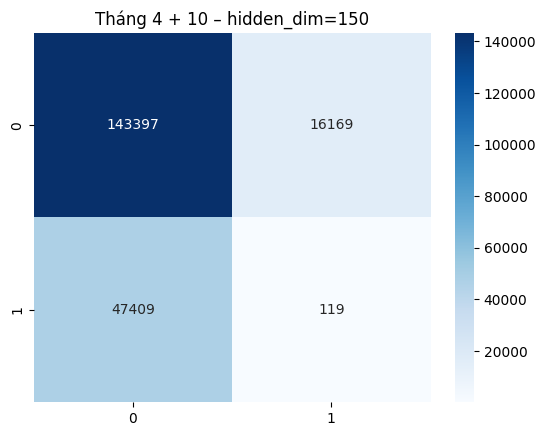

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# ——— Utility functions ———
def softmax(Z):
    # Ensure Z is a numpy array of shape (n_samples, n_classes)
    Z_arr = Z.values if hasattr(Z, "values") else np.array(Z)
    # 1) subtract the max for numerical stability
    #    max_per_row: shape (n_samples,)
    max_per_row = np.max(Z_arr, axis=1)
    #    reshape to (n_samples, 1) so broadcasting works
    max_per_row = max_per_row.reshape(-1, 1)
    # 2) exponentiate
    expZ = np.exp(Z_arr - max_per_row)
    # 3) sum per row, then reshape to (n_samples, 1)
    sum_per_row = np.sum(expZ, axis=1).reshape(-1, 1)
    # 4) divide
    return expZ / sum_per_row

def pack(W1, b1, W2, b2):
    """
    Flatten and concatenate parameters, handling pandas DataFrame/Series inputs.
    """
    # Convert DataFrame/Series to numpy arrays
    W1_arr = W1.values if isinstance(W1, pd.DataFrame) else np.array(W1)
    b1_arr = b1.values if isinstance(b1, (pd.Series, pd.DataFrame)) else np.array(b1)
    W2_arr = W2.values if isinstance(W2, pd.DataFrame) else np.array(W2)
    b2_arr = b2.values if isinstance(b2, (pd.Series, pd.DataFrame)) else np.array(b2)
    # Flatten and concatenate
    return np.hstack([
        W1_arr.ravel(),
        b1_arr.ravel(),
        W2_arr.ravel(),
        b2_arr.ravel()
    ])

def unpack(p, input_dim, hidden_dim, output_dim):
    idx = 0
    W1 = p[idx:idx + hidden_dim*input_dim].reshape(hidden_dim, input_dim)
    idx += hidden_dim*input_dim
    b1 = p[idx:idx + hidden_dim]
    idx += hidden_dim
    W2 = p[idx:idx + output_dim*hidden_dim].reshape(output_dim, hidden_dim)
    idx += output_dim*hidden_dim
    b2 = p[idx:idx + output_dim]
    return W1, b1, W2, b2

def trainscg(loss_grad_func, x0, epochs=8, **lg_kwargs):
    sigma0, lambd = 1e-6, 1e-6
    x = x0.copy()
    f, g = loss_grad_func(x, **lg_kwargs)
    d = -g
    errors = [f]
    for epoch in range(epochs):
        mu = d.dot(d)
        sigma = sigma0 / np.sqrt(mu) if mu > 0 else sigma0
        _, g1 = loss_grad_func(x + sigma*d, **lg_kwargs)
        s = (g1 - g) / sigma
        delta = d.dot(s)
        if delta <= 0:
            delta = lambd * mu
            lambd -= delta / mu
        alpha = -d.dot(g) / (delta + lambd*mu)
        x_new = x + alpha*d
        f_new, g_new = loss_grad_func(x_new, **lg_kwargs)
        Delta = 2*(f - f_new) / (alpha * d.dot(g))
        if Delta >= 0:
            x, f, g = x_new, f_new, g_new
            lambd *= max(1/3, 1 - (2*Delta - 1)**3)
            beta = (g.dot(g) - g.dot(g_new)) / (d.dot(g))
            d = -g + beta*d
        else:
            lambd += mu * (1 - Delta)
        errors.append(f)
    return x, errors

def loss_grad_factory(X, Y_oh, input_dim, hidden_dim, output_dim):
    def loss_and_grad(p):
        W1, b1, W2, b2 = unpack(p, input_dim, hidden_dim, output_dim)
        m = X.shape[0]
        Z1 = X.dot(W1.T) + b1
        A1 = np.tanh(Z1)
        Z2 = A1.dot(W2.T) + b2
        A2 = softmax(Z2)
        loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
        dZ2 = (A2 - Y_oh) / m
        dW2 = dZ2.T.dot(A1)
        db2 = dZ2.sum(axis=0)
        dA1 = dZ2.dot(W2)
        dZ1 = dA1 * (1 - np.tanh(Z1)**2)
        dW1 = dZ1.T.dot(X)
        db1 = dZ1.sum(axis=0)
        return loss, pack(dW1, db1, dW2, db2)
    return loss_and_grad

param_grid = {'hidden_dim': [10, 20, 50, 100, 150, 17, 25, 34, 50, 68, 85]}

for name, X_trval, y_trval, X_test, y_test in models_info:
    print(f"\n=== Dataset: {name} ===")
    # split train+val from test
    X_trval = X_trval[top_features]
    X_test = X_test[top_features]
    X_train, X_val, y_train, y_val = train_test_split(
        X_trval, y_trval, test_size=0.2, random_state=42
    )
    # one-hot encode y_train
    y_arr = y_train.to_numpy().reshape(-1, 1)
    encoder = OneHotEncoder(sparse=False, categories='auto')
    Y_train_oh = encoder.fit_transform(y_arr.reshape(-1,1))
    y_arv = y_val.to_numpy().reshape(-1, 1)
    Y_val_oh   = encoder.transform(y_arv.reshape(-1,1))
    # final test encoding not needed for training
    
    # scale assumed done before, X_trval and X_test are already scaled
    
    input_dim  = X_train.shape[1]
    output_dim = Y_train_oh.shape[1]

    best_h, best_loss = None, np.inf
    for h in param_grid['hidden_dim']:
        # init params
        param_size  = h*input_dim + h + output_dim*h + output_dim
        init_p = 0.01 * np.random.randn(param_size)
        # train SCG
        lg = loss_grad_factory(X_train, Y_train_oh, input_dim, h, output_dim)
        opt_p, _ = trainscg(lg, init_p, epochs=8)
        # predict on val
        W1, b1, W2, b2 = unpack(opt_p, input_dim, h, output_dim)
        Z1_val = X_val.dot(W1.T) + b1
        A1_val = np.tanh(Z1_val)
        Z2_val = A1_val.dot(W2.T) + b2
        A2_val = softmax(Z2_val)
        val_loss = -np.mean(np.sum(Y_val_oh * np.log(A2_val + 1e-12), axis=1))
        print(f" hidden_dim={h:<3} → val loss = {val_loss:.6f}")
        if val_loss < best_loss:
            best_loss, best_h = val_loss, h
    
    print(f"⇒ Best hidden_dim = {best_h}, validation loss = {best_loss:.6f}")

    X_full = np.vstack([X_train, X_val])
    y_full = np.hstack([y_train, y_val])
    Y_full_oh = encoder.fit_transform(y_full.reshape(-1,1))
    param_size  = best_h*input_dim + best_h + output_dim*best_h + output_dim
    init_p_full = 0.01 * np.random.randn(param_size)
    lg_full = loss_grad_factory(X_full, Y_full_oh, input_dim, best_h, output_dim)
    opt_p_full, loss_hist = trainscg(lg_full, init_p_full, epochs=8)
    
    # evaluate on test
    W1f, b1f, W2f, b2f = unpack(opt_p_full, input_dim, best_h, output_dim)
    A1_test = np.tanh(X_test.dot(W1f.T) + b1f)
    probs_test = softmax(A1_test.dot(W2f.T) + b2f)
    preds_test = np.argmax(probs_test, axis=1)
    
    print("Test classification report:")
    print(classification_report(y_test, preds_test))
    cm = confusion_matrix(y_test, preds_test)
    print("Test confusion matrix:\n", cm)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} – hidden_dim={best_h}")
    plt.show()

# 6. Cân bằng dữ liệu (Oversampling)

## 6.1 SMOTE

In [15]:
# SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [16]:
models_info = [
    ("Tháng 4 + 10 smote", X_train_scaled, y_sm, X_test_scaled, y_test),
]


=== Dataset: Tháng 4 + 10 smote ===
 hidden_dim=10  → val loss = 0.716960
 hidden_dim=20  → val loss = 0.693220


/tmp/ipykernel_13/2373381110.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_o

 hidden_dim=50  → val loss = 6.761277
 hidden_dim=100 → val loss = 0.693274
 hidden_dim=150 → val loss = 0.692800
 hidden_dim=17  → val loss = 0.693486
 hidden_dim=25  → val loss = 0.693438


/tmp/ipykernel_13/2373381110.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_o

 hidden_dim=34  → val loss = 6.759082
 hidden_dim=50  → val loss = 0.693592


/tmp/ipykernel_13/2373381110.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_o

 hidden_dim=68  → val loss = 20.873036
 hidden_dim=85  → val loss = 0.693199
⇒ Best hidden_dim = 150, validation loss = 0.692800
Test classification report:
              precision    recall  f1-score   support

           0       0.99      0.40      0.57    159566
           1       0.33      0.99      0.49     47528

    accuracy                           0.53    207094
   macro avg       0.66      0.69      0.53    207094
weighted avg       0.84      0.53      0.55    207094

Test confusion matrix:
 [[63502 96064]
 [  628 46900]]


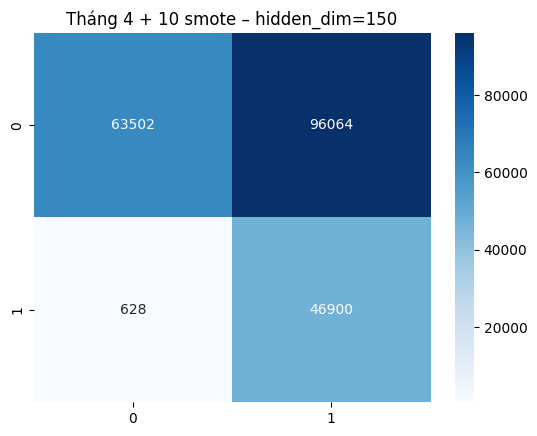

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# ——— Utility functions ———
def softmax(Z):
    # Ensure Z is a numpy array of shape (n_samples, n_classes)
    Z_arr = Z.values if hasattr(Z, "values") else np.array(Z)
    # 1) subtract the max for numerical stability
    #    max_per_row: shape (n_samples,)
    max_per_row = np.max(Z_arr, axis=1)
    #    reshape to (n_samples, 1) so broadcasting works
    max_per_row = max_per_row.reshape(-1, 1)
    # 2) exponentiate
    expZ = np.exp(Z_arr - max_per_row)
    # 3) sum per row, then reshape to (n_samples, 1)
    sum_per_row = np.sum(expZ, axis=1).reshape(-1, 1)
    # 4) divide
    return expZ / sum_per_row

def pack(W1, b1, W2, b2):
    """
    Flatten and concatenate parameters, handling pandas DataFrame/Series inputs.
    """
    # Convert DataFrame/Series to numpy arrays
    W1_arr = W1.values if isinstance(W1, pd.DataFrame) else np.array(W1)
    b1_arr = b1.values if isinstance(b1, (pd.Series, pd.DataFrame)) else np.array(b1)
    W2_arr = W2.values if isinstance(W2, pd.DataFrame) else np.array(W2)
    b2_arr = b2.values if isinstance(b2, (pd.Series, pd.DataFrame)) else np.array(b2)
    # Flatten and concatenate
    return np.hstack([
        W1_arr.ravel(),
        b1_arr.ravel(),
        W2_arr.ravel(),
        b2_arr.ravel()
    ])

def unpack(p, input_dim, hidden_dim, output_dim):
    idx = 0
    W1 = p[idx:idx + hidden_dim*input_dim].reshape(hidden_dim, input_dim)
    idx += hidden_dim*input_dim
    b1 = p[idx:idx + hidden_dim]
    idx += hidden_dim
    W2 = p[idx:idx + output_dim*hidden_dim].reshape(output_dim, hidden_dim)
    idx += output_dim*hidden_dim
    b2 = p[idx:idx + output_dim]
    return W1, b1, W2, b2

def trainscg(loss_grad_func, x0, epochs=8, **lg_kwargs):
    sigma0, lambd = 1e-6, 1e-6
    x = x0.copy()
    f, g = loss_grad_func(x, **lg_kwargs)
    d = -g
    errors = [f]
    for epoch in range(epochs):
        mu = d.dot(d)
        sigma = sigma0 / np.sqrt(mu) if mu > 0 else sigma0
        _, g1 = loss_grad_func(x + sigma*d, **lg_kwargs)
        s = (g1 - g) / sigma
        delta = d.dot(s)
        if delta <= 0:
            delta = lambd * mu
            lambd -= delta / mu
        alpha = -d.dot(g) / (delta + lambd*mu)
        x_new = x + alpha*d
        f_new, g_new = loss_grad_func(x_new, **lg_kwargs)
        Delta = 2*(f - f_new) / (alpha * d.dot(g))
        if Delta >= 0:
            x, f, g = x_new, f_new, g_new
            lambd *= max(1/3, 1 - (2*Delta - 1)**3)
            beta = (g.dot(g) - g.dot(g_new)) / (d.dot(g))
            d = -g + beta*d
        else:
            lambd += mu * (1 - Delta)
        errors.append(f)
    return x, errors

def loss_grad_factory(X, Y_oh, input_dim, hidden_dim, output_dim):
    def loss_and_grad(p):
        W1, b1, W2, b2 = unpack(p, input_dim, hidden_dim, output_dim)
        m = X.shape[0]
        Z1 = X.dot(W1.T) + b1
        A1 = np.tanh(Z1)
        Z2 = A1.dot(W2.T) + b2
        A2 = softmax(Z2)
        loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
        dZ2 = (A2 - Y_oh) / m
        dW2 = dZ2.T.dot(A1)
        db2 = dZ2.sum(axis=0)
        dA1 = dZ2.dot(W2)
        dZ1 = dA1 * (1 - np.tanh(Z1)**2)
        dW1 = dZ1.T.dot(X)
        db1 = dZ1.sum(axis=0)
        return loss, pack(dW1, db1, dW2, db2)
    return loss_and_grad

param_grid = {'hidden_dim': [10, 20, 50, 100, 150, 17, 25, 34, 50, 68, 85]}

for name, X_trval, y_trval, X_test, y_test in models_info:
    print(f"\n=== Dataset: {name} ===")
    # split train+val from test
    # X_trval = X_trval[top_features]
    # X_test = X_test[top_features]
    X_train, X_val, y_train, y_val = train_test_split(
        X_trval, y_trval, test_size=0.2, random_state=42
    )
    # one-hot encode y_train
    y_arr = y_train.to_numpy().reshape(-1, 1)
    encoder = OneHotEncoder(sparse=False, categories='auto')
    Y_train_oh = encoder.fit_transform(y_arr.reshape(-1,1))
    y_arv = y_val.to_numpy().reshape(-1, 1)
    Y_val_oh   = encoder.transform(y_arv.reshape(-1,1))
    # final test encoding not needed for training
    
    # scale assumed done before, X_trval and X_test are already scaled
    
    input_dim  = X_train.shape[1]
    output_dim = Y_train_oh.shape[1]

    best_h, best_loss = None, np.inf
    for h in param_grid['hidden_dim']:
        # init params
        param_size  = h*input_dim + h + output_dim*h + output_dim
        init_p = 0.01 * np.random.randn(param_size)
        # train SCG
        lg = loss_grad_factory(X_train, Y_train_oh, input_dim, h, output_dim)
        opt_p, _ = trainscg(lg, init_p, epochs=8)
        # predict on val
        W1, b1, W2, b2 = unpack(opt_p, input_dim, h, output_dim)
        Z1_val = X_val.dot(W1.T) + b1
        A1_val = np.tanh(Z1_val)
        Z2_val = A1_val.dot(W2.T) + b2
        A2_val = softmax(Z2_val)
        val_loss = -np.mean(np.sum(Y_val_oh * np.log(A2_val + 1e-12), axis=1))
        print(f" hidden_dim={h:<3} → val loss = {val_loss:.6f}")
        if val_loss < best_loss:
            best_loss, best_h = val_loss, h
    
    print(f"⇒ Best hidden_dim = {best_h}, validation loss = {best_loss:.6f}")

    X_full = np.vstack([X_train, X_val])
    y_full = np.hstack([y_train, y_val])
    Y_full_oh = encoder.fit_transform(y_full.reshape(-1,1))
    param_size  = best_h*input_dim + best_h + output_dim*best_h + output_dim
    init_p_full = 0.01 * np.random.randn(param_size)
    lg_full = loss_grad_factory(X_full, Y_full_oh, input_dim, best_h, output_dim)
    opt_p_full, loss_hist = trainscg(lg_full, init_p_full, epochs=8)
    
    # evaluate on test
    W1f, b1f, W2f, b2f = unpack(opt_p_full, input_dim, best_h, output_dim)
    A1_test = np.tanh(X_test.dot(W1f.T) + b1f)
    probs_test = softmax(A1_test.dot(W2f.T) + b2f)
    preds_test = np.argmax(probs_test, axis=1)
    
    print("Test classification report:")
    print(classification_report(y_test, preds_test))
    cm = confusion_matrix(y_test, preds_test)
    print("Test confusion matrix:\n", cm)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} – hidden_dim={best_h}")
    plt.show()


=== Dataset: Tháng 4 + 10 smote ===
 hidden_dim=10  → val loss = 0.693177
 hidden_dim=20  → val loss = 0.693464
 hidden_dim=50  → val loss = 6.755791


/tmp/ipykernel_13/170896461.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np

 hidden_dim=100 → val loss = 6.760179
 hidden_dim=150 → val loss = 1.900930
 hidden_dim=17  → val loss = 0.693486
 hidden_dim=25  → val loss = 0.693371
 hidden_dim=34  → val loss = 0.693491
 hidden_dim=50  → val loss = 0.693823
 hidden_dim=68  → val loss = 20.870842


/tmp/ipykernel_13/170896461.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np

 hidden_dim=85  → val loss = 6.763252
⇒ Best hidden_dim = 10, validation loss = 0.693177
Test classification report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.77      1.00      0.87    159566
           1       0.00      0.00      0.00     47528

    accuracy                           0.77    207094
   macro avg       0.39      0.50      0.44    207094
weighted avg       0.59      0.77      0.67    207094

Test confusion matrix:
 [[159566      0]
 [ 47528      0]]


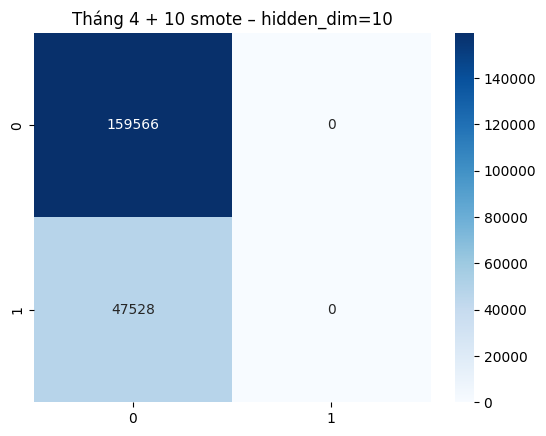

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# ——— Utility functions ———
def softmax(Z):
    # Ensure Z is a numpy array of shape (n_samples, n_classes)
    Z_arr = Z.values if hasattr(Z, "values") else np.array(Z)
    # 1) subtract the max for numerical stability
    #    max_per_row: shape (n_samples,)
    max_per_row = np.max(Z_arr, axis=1)
    #    reshape to (n_samples, 1) so broadcasting works
    max_per_row = max_per_row.reshape(-1, 1)
    # 2) exponentiate
    expZ = np.exp(Z_arr - max_per_row)
    # 3) sum per row, then reshape to (n_samples, 1)
    sum_per_row = np.sum(expZ, axis=1).reshape(-1, 1)
    # 4) divide
    return expZ / sum_per_row

def pack(W1, b1, W2, b2):
    """
    Flatten and concatenate parameters, handling pandas DataFrame/Series inputs.
    """
    # Convert DataFrame/Series to numpy arrays
    W1_arr = W1.values if isinstance(W1, pd.DataFrame) else np.array(W1)
    b1_arr = b1.values if isinstance(b1, (pd.Series, pd.DataFrame)) else np.array(b1)
    W2_arr = W2.values if isinstance(W2, pd.DataFrame) else np.array(W2)
    b2_arr = b2.values if isinstance(b2, (pd.Series, pd.DataFrame)) else np.array(b2)
    # Flatten and concatenate
    return np.hstack([
        W1_arr.ravel(),
        b1_arr.ravel(),
        W2_arr.ravel(),
        b2_arr.ravel()
    ])

def unpack(p, input_dim, hidden_dim, output_dim):
    idx = 0
    W1 = p[idx:idx + hidden_dim*input_dim].reshape(hidden_dim, input_dim)
    idx += hidden_dim*input_dim
    b1 = p[idx:idx + hidden_dim]
    idx += hidden_dim
    W2 = p[idx:idx + output_dim*hidden_dim].reshape(output_dim, hidden_dim)
    idx += output_dim*hidden_dim
    b2 = p[idx:idx + output_dim]
    return W1, b1, W2, b2

def trainscg(loss_grad_func, x0, epochs=8, **lg_kwargs):
    sigma0, lambd = 1e-6, 1e-6
    x = x0.copy()
    f, g = loss_grad_func(x, **lg_kwargs)
    d = -g
    errors = [f]
    for epoch in range(epochs):
        mu = d.dot(d)
        sigma = sigma0 / np.sqrt(mu) if mu > 0 else sigma0
        _, g1 = loss_grad_func(x + sigma*d, **lg_kwargs)
        s = (g1 - g) / sigma
        delta = d.dot(s)
        if delta <= 0:
            delta = lambd * mu
            lambd -= delta / mu
        alpha = -d.dot(g) / (delta + lambd*mu)
        x_new = x + alpha*d
        f_new, g_new = loss_grad_func(x_new, **lg_kwargs)
        Delta = 2*(f - f_new) / (alpha * d.dot(g))
        if Delta >= 0:
            x, f, g = x_new, f_new, g_new
            lambd *= max(1/3, 1 - (2*Delta - 1)**3)
            beta = (g.dot(g) - g.dot(g_new)) / (d.dot(g))
            d = -g + beta*d
        else:
            lambd += mu * (1 - Delta)
        errors.append(f)
    return x, errors

def loss_grad_factory(X, Y_oh, input_dim, hidden_dim, output_dim):
    def loss_and_grad(p):
        W1, b1, W2, b2 = unpack(p, input_dim, hidden_dim, output_dim)
        m = X.shape[0]
        Z1 = X.dot(W1.T) + b1
        A1 = np.tanh(Z1)
        Z2 = A1.dot(W2.T) + b2
        A2 = softmax(Z2)
        loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
        dZ2 = (A2 - Y_oh) / m
        dW2 = dZ2.T.dot(A1)
        db2 = dZ2.sum(axis=0)
        dA1 = dZ2.dot(W2)
        dZ1 = dA1 * (1 - np.tanh(Z1)**2)
        dW1 = dZ1.T.dot(X)
        db1 = dZ1.sum(axis=0)
        return loss, pack(dW1, db1, dW2, db2)
    return loss_and_grad

param_grid = {'hidden_dim': [10, 20, 50, 100, 150, 17, 25, 34, 50, 68, 85]}

for name, X_trval, y_trval, X_test, y_test in models_info:
    print(f"\n=== Dataset: {name} ===")
    # split train+val from test
    X_trval = X_trval[top_features]
    X_test = X_test[top_features]
    X_train, X_val, y_train, y_val = train_test_split(
        X_trval, y_trval, test_size=0.2, random_state=42
    )
    # one-hot encode y_train
    y_arr = y_train.to_numpy().reshape(-1, 1)
    encoder = OneHotEncoder(sparse=False, categories='auto')
    Y_train_oh = encoder.fit_transform(y_arr.reshape(-1,1))
    y_arv = y_val.to_numpy().reshape(-1, 1)
    Y_val_oh   = encoder.transform(y_arv.reshape(-1,1))
    # final test encoding not needed for training
    
    # scale assumed done before, X_trval and X_test are already scaled
    
    input_dim  = X_train.shape[1]
    output_dim = Y_train_oh.shape[1]

    best_h, best_loss = None, np.inf
    for h in param_grid['hidden_dim']:
        # init params
        param_size  = h*input_dim + h + output_dim*h + output_dim
        init_p = 0.01 * np.random.randn(param_size)
        # train SCG
        lg = loss_grad_factory(X_train, Y_train_oh, input_dim, h, output_dim)
        opt_p, _ = trainscg(lg, init_p, epochs=8)
        # predict on val
        W1, b1, W2, b2 = unpack(opt_p, input_dim, h, output_dim)
        Z1_val = X_val.dot(W1.T) + b1
        A1_val = np.tanh(Z1_val)
        Z2_val = A1_val.dot(W2.T) + b2
        A2_val = softmax(Z2_val)
        val_loss = -np.mean(np.sum(Y_val_oh * np.log(A2_val + 1e-12), axis=1))
        print(f" hidden_dim={h:<3} → val loss = {val_loss:.6f}")
        if val_loss < best_loss:
            best_loss, best_h = val_loss, h
    
    print(f"⇒ Best hidden_dim = {best_h}, validation loss = {best_loss:.6f}")

    X_full = np.vstack([X_train, X_val])
    y_full = np.hstack([y_train, y_val])
    Y_full_oh = encoder.fit_transform(y_full.reshape(-1,1))
    param_size  = best_h*input_dim + best_h + output_dim*best_h + output_dim
    init_p_full = 0.01 * np.random.randn(param_size)
    lg_full = loss_grad_factory(X_full, Y_full_oh, input_dim, best_h, output_dim)
    opt_p_full, loss_hist = trainscg(lg_full, init_p_full, epochs=8)
    
    # evaluate on test
    W1f, b1f, W2f, b2f = unpack(opt_p_full, input_dim, best_h, output_dim)
    A1_test = np.tanh(X_test.dot(W1f.T) + b1f)
    probs_test = softmax(A1_test.dot(W2f.T) + b2f)
    preds_test = np.argmax(probs_test, axis=1)
    
    print("Test classification report:")
    print(classification_report(y_test, preds_test))
    cm = confusion_matrix(y_test, preds_test)
    print("Test confusion matrix:\n", cm)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} – hidden_dim={best_h}")
    plt.show()

## 6.2 SMOTE ENN

In [19]:
# SMOTE ENN
from imblearn.combine import SMOTEENN

smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [20]:
models_info = [
    ("Tháng 4 + 10 smote", X_train_scaled, y_smenn, X_test_scaled, y_test),
]


=== Dataset: Tháng 4 + 10 smote ===
 hidden_dim=10  → val loss = 5.652796
 hidden_dim=20  → val loss = 0.694259
 hidden_dim=50  → val loss = 0.693025
 hidden_dim=100 → val loss = 0.694030
 hidden_dim=150 → val loss = 0.693775
 hidden_dim=17  → val loss = 5.352884
 hidden_dim=25  → val loss = 0.693560


/tmp/ipykernel_13/2373381110.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2373381110.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_o

 hidden_dim=34  → val loss = 13.403434
 hidden_dim=50  → val loss = 0.693734
 hidden_dim=68  → val loss = 0.693996
 hidden_dim=85  → val loss = 0.694495
⇒ Best hidden_dim = 50, validation loss = 0.693025
Test classification report:
              precision    recall  f1-score   support

           0       0.99      0.39      0.56    159566
           1       0.32      0.99      0.49     47528

    accuracy                           0.52    207094
   macro avg       0.66      0.69      0.52    207094
weighted avg       0.84      0.52      0.54    207094

Test confusion matrix:
 [[61625 97941]
 [  588 46940]]


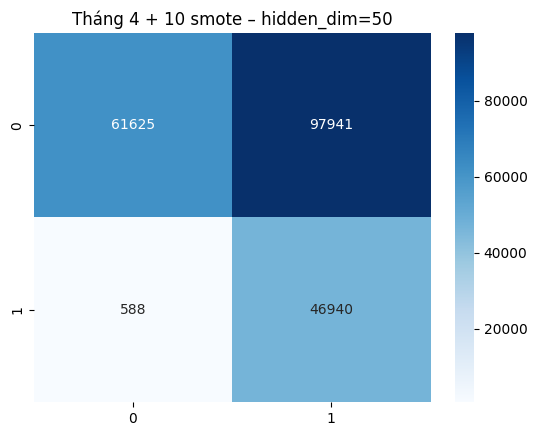

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# ——— Utility functions ———
def softmax(Z):
    # Ensure Z is a numpy array of shape (n_samples, n_classes)
    Z_arr = Z.values if hasattr(Z, "values") else np.array(Z)
    # 1) subtract the max for numerical stability
    #    max_per_row: shape (n_samples,)
    max_per_row = np.max(Z_arr, axis=1)
    #    reshape to (n_samples, 1) so broadcasting works
    max_per_row = max_per_row.reshape(-1, 1)
    # 2) exponentiate
    expZ = np.exp(Z_arr - max_per_row)
    # 3) sum per row, then reshape to (n_samples, 1)
    sum_per_row = np.sum(expZ, axis=1).reshape(-1, 1)
    # 4) divide
    return expZ / sum_per_row

def pack(W1, b1, W2, b2):
    """
    Flatten and concatenate parameters, handling pandas DataFrame/Series inputs.
    """
    # Convert DataFrame/Series to numpy arrays
    W1_arr = W1.values if isinstance(W1, pd.DataFrame) else np.array(W1)
    b1_arr = b1.values if isinstance(b1, (pd.Series, pd.DataFrame)) else np.array(b1)
    W2_arr = W2.values if isinstance(W2, pd.DataFrame) else np.array(W2)
    b2_arr = b2.values if isinstance(b2, (pd.Series, pd.DataFrame)) else np.array(b2)
    # Flatten and concatenate
    return np.hstack([
        W1_arr.ravel(),
        b1_arr.ravel(),
        W2_arr.ravel(),
        b2_arr.ravel()
    ])

def unpack(p, input_dim, hidden_dim, output_dim):
    idx = 0
    W1 = p[idx:idx + hidden_dim*input_dim].reshape(hidden_dim, input_dim)
    idx += hidden_dim*input_dim
    b1 = p[idx:idx + hidden_dim]
    idx += hidden_dim
    W2 = p[idx:idx + output_dim*hidden_dim].reshape(output_dim, hidden_dim)
    idx += output_dim*hidden_dim
    b2 = p[idx:idx + output_dim]
    return W1, b1, W2, b2

def trainscg(loss_grad_func, x0, epochs=8, **lg_kwargs):
    sigma0, lambd = 1e-6, 1e-6
    x = x0.copy()
    f, g = loss_grad_func(x, **lg_kwargs)
    d = -g
    errors = [f]
    for epoch in range(epochs):
        mu = d.dot(d)
        sigma = sigma0 / np.sqrt(mu) if mu > 0 else sigma0
        _, g1 = loss_grad_func(x + sigma*d, **lg_kwargs)
        s = (g1 - g) / sigma
        delta = d.dot(s)
        if delta <= 0:
            delta = lambd * mu
            lambd -= delta / mu
        alpha = -d.dot(g) / (delta + lambd*mu)
        x_new = x + alpha*d
        f_new, g_new = loss_grad_func(x_new, **lg_kwargs)
        Delta = 2*(f - f_new) / (alpha * d.dot(g))
        if Delta >= 0:
            x, f, g = x_new, f_new, g_new
            lambd *= max(1/3, 1 - (2*Delta - 1)**3)
            beta = (g.dot(g) - g.dot(g_new)) / (d.dot(g))
            d = -g + beta*d
        else:
            lambd += mu * (1 - Delta)
        errors.append(f)
    return x, errors

def loss_grad_factory(X, Y_oh, input_dim, hidden_dim, output_dim):
    def loss_and_grad(p):
        W1, b1, W2, b2 = unpack(p, input_dim, hidden_dim, output_dim)
        m = X.shape[0]
        Z1 = X.dot(W1.T) + b1
        A1 = np.tanh(Z1)
        Z2 = A1.dot(W2.T) + b2
        A2 = softmax(Z2)
        loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
        dZ2 = (A2 - Y_oh) / m
        dW2 = dZ2.T.dot(A1)
        db2 = dZ2.sum(axis=0)
        dA1 = dZ2.dot(W2)
        dZ1 = dA1 * (1 - np.tanh(Z1)**2)
        dW1 = dZ1.T.dot(X)
        db1 = dZ1.sum(axis=0)
        return loss, pack(dW1, db1, dW2, db2)
    return loss_and_grad

param_grid = {'hidden_dim': [10, 20, 50, 100, 150, 17, 25, 34, 50, 68, 85]}

for name, X_trval, y_trval, X_test, y_test in models_info:
    print(f"\n=== Dataset: {name} ===")
    # split train+val from test
    # X_trval = X_trval[top_features]
    # X_test = X_test[top_features]
    X_train, X_val, y_train, y_val = train_test_split(
        X_trval, y_trval, test_size=0.2, random_state=42
    )
    # one-hot encode y_train
    y_arr = y_train.to_numpy().reshape(-1, 1)
    encoder = OneHotEncoder(sparse=False, categories='auto')
    Y_train_oh = encoder.fit_transform(y_arr.reshape(-1,1))
    y_arv = y_val.to_numpy().reshape(-1, 1)
    Y_val_oh   = encoder.transform(y_arv.reshape(-1,1))
    # final test encoding not needed for training
    
    # scale assumed done before, X_trval and X_test are already scaled
    
    input_dim  = X_train.shape[1]
    output_dim = Y_train_oh.shape[1]

    best_h, best_loss = None, np.inf
    for h in param_grid['hidden_dim']:
        # init params
        param_size  = h*input_dim + h + output_dim*h + output_dim
        init_p = 0.01 * np.random.randn(param_size)
        # train SCG
        lg = loss_grad_factory(X_train, Y_train_oh, input_dim, h, output_dim)
        opt_p, _ = trainscg(lg, init_p, epochs=8)
        # predict on val
        W1, b1, W2, b2 = unpack(opt_p, input_dim, h, output_dim)
        Z1_val = X_val.dot(W1.T) + b1
        A1_val = np.tanh(Z1_val)
        Z2_val = A1_val.dot(W2.T) + b2
        A2_val = softmax(Z2_val)
        val_loss = -np.mean(np.sum(Y_val_oh * np.log(A2_val + 1e-12), axis=1))
        print(f" hidden_dim={h:<3} → val loss = {val_loss:.6f}")
        if val_loss < best_loss:
            best_loss, best_h = val_loss, h
    
    print(f"⇒ Best hidden_dim = {best_h}, validation loss = {best_loss:.6f}")

    X_full = np.vstack([X_train, X_val])
    y_full = np.hstack([y_train, y_val])
    Y_full_oh = encoder.fit_transform(y_full.reshape(-1,1))
    param_size  = best_h*input_dim + best_h + output_dim*best_h + output_dim
    init_p_full = 0.01 * np.random.randn(param_size)
    lg_full = loss_grad_factory(X_full, Y_full_oh, input_dim, best_h, output_dim)
    opt_p_full, loss_hist = trainscg(lg_full, init_p_full, epochs=8)
    
    # evaluate on test
    W1f, b1f, W2f, b2f = unpack(opt_p_full, input_dim, best_h, output_dim)
    A1_test = np.tanh(X_test.dot(W1f.T) + b1f)
    probs_test = softmax(A1_test.dot(W2f.T) + b2f)
    preds_test = np.argmax(probs_test, axis=1)
    
    print("Test classification report:")
    print(classification_report(y_test, preds_test))
    cm = confusion_matrix(y_test, preds_test)
    print("Test confusion matrix:\n", cm)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} – hidden_dim={best_h}")
    plt.show()


=== Dataset: Tháng 4 + 10 smote ===
 hidden_dim=10  → val loss = 0.693449


/tmp/ipykernel_13/170896461.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np

 hidden_dim=20  → val loss = 5.657148
 hidden_dim=50  → val loss = 0.693902
 hidden_dim=100 → val loss = 0.693006
 hidden_dim=150 → val loss = 0.694925
 hidden_dim=17  → val loss = 0.693675
 hidden_dim=25  → val loss = 0.693761
 hidden_dim=34  → val loss = 0.693124
 hidden_dim=50  → val loss = 0.693079
 hidden_dim=68  → val loss = 0.693527


/tmp/ipykernel_13/170896461.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/170896461.py:89: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np

 hidden_dim=85  → val loss = 5.649998
⇒ Best hidden_dim = 100, validation loss = 0.693006
Test classification report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.77      1.00      0.87    159566
           1       0.00      0.00      0.00     47528

    accuracy                           0.77    207094
   macro avg       0.39      0.50      0.44    207094
weighted avg       0.59      0.77      0.67    207094

Test confusion matrix:
 [[159566      0]
 [ 47528      0]]


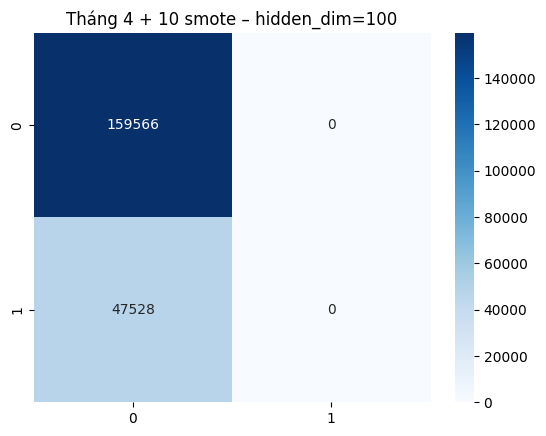

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# ——— Utility functions ———
def softmax(Z):
    # Ensure Z is a numpy array of shape (n_samples, n_classes)
    Z_arr = Z.values if hasattr(Z, "values") else np.array(Z)
    # 1) subtract the max for numerical stability
    #    max_per_row: shape (n_samples,)
    max_per_row = np.max(Z_arr, axis=1)
    #    reshape to (n_samples, 1) so broadcasting works
    max_per_row = max_per_row.reshape(-1, 1)
    # 2) exponentiate
    expZ = np.exp(Z_arr - max_per_row)
    # 3) sum per row, then reshape to (n_samples, 1)
    sum_per_row = np.sum(expZ, axis=1).reshape(-1, 1)
    # 4) divide
    return expZ / sum_per_row

def pack(W1, b1, W2, b2):
    """
    Flatten and concatenate parameters, handling pandas DataFrame/Series inputs.
    """
    # Convert DataFrame/Series to numpy arrays
    W1_arr = W1.values if isinstance(W1, pd.DataFrame) else np.array(W1)
    b1_arr = b1.values if isinstance(b1, (pd.Series, pd.DataFrame)) else np.array(b1)
    W2_arr = W2.values if isinstance(W2, pd.DataFrame) else np.array(W2)
    b2_arr = b2.values if isinstance(b2, (pd.Series, pd.DataFrame)) else np.array(b2)
    # Flatten and concatenate
    return np.hstack([
        W1_arr.ravel(),
        b1_arr.ravel(),
        W2_arr.ravel(),
        b2_arr.ravel()
    ])

def unpack(p, input_dim, hidden_dim, output_dim):
    idx = 0
    W1 = p[idx:idx + hidden_dim*input_dim].reshape(hidden_dim, input_dim)
    idx += hidden_dim*input_dim
    b1 = p[idx:idx + hidden_dim]
    idx += hidden_dim
    W2 = p[idx:idx + output_dim*hidden_dim].reshape(output_dim, hidden_dim)
    idx += output_dim*hidden_dim
    b2 = p[idx:idx + output_dim]
    return W1, b1, W2, b2

def trainscg(loss_grad_func, x0, epochs=8, **lg_kwargs):
    sigma0, lambd = 1e-6, 1e-6
    x = x0.copy()
    f, g = loss_grad_func(x, **lg_kwargs)
    d = -g
    errors = [f]
    for epoch in range(epochs):
        mu = d.dot(d)
        sigma = sigma0 / np.sqrt(mu) if mu > 0 else sigma0
        _, g1 = loss_grad_func(x + sigma*d, **lg_kwargs)
        s = (g1 - g) / sigma
        delta = d.dot(s)
        if delta <= 0:
            delta = lambd * mu
            lambd -= delta / mu
        alpha = -d.dot(g) / (delta + lambd*mu)
        x_new = x + alpha*d
        f_new, g_new = loss_grad_func(x_new, **lg_kwargs)
        Delta = 2*(f - f_new) / (alpha * d.dot(g))
        if Delta >= 0:
            x, f, g = x_new, f_new, g_new
            lambd *= max(1/3, 1 - (2*Delta - 1)**3)
            beta = (g.dot(g) - g.dot(g_new)) / (d.dot(g))
            d = -g + beta*d
        else:
            lambd += mu * (1 - Delta)
        errors.append(f)
    return x, errors

def loss_grad_factory(X, Y_oh, input_dim, hidden_dim, output_dim):
    def loss_and_grad(p):
        W1, b1, W2, b2 = unpack(p, input_dim, hidden_dim, output_dim)
        m = X.shape[0]
        Z1 = X.dot(W1.T) + b1
        A1 = np.tanh(Z1)
        Z2 = A1.dot(W2.T) + b2
        A2 = softmax(Z2)
        loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
        dZ2 = (A2 - Y_oh) / m
        dW2 = dZ2.T.dot(A1)
        db2 = dZ2.sum(axis=0)
        dA1 = dZ2.dot(W2)
        dZ1 = dA1 * (1 - np.tanh(Z1)**2)
        dW1 = dZ1.T.dot(X)
        db1 = dZ1.sum(axis=0)
        return loss, pack(dW1, db1, dW2, db2)
    return loss_and_grad

param_grid = {'hidden_dim': [10, 20, 50, 100, 150, 17, 25, 34, 50, 68, 85]}

for name, X_trval, y_trval, X_test, y_test in models_info:
    print(f"\n=== Dataset: {name} ===")
    # split train+val from test
    X_trval = X_trval[top_features]
    X_test = X_test[top_features]
    X_train, X_val, y_train, y_val = train_test_split(
        X_trval, y_trval, test_size=0.2, random_state=42
    )
    # one-hot encode y_train
    y_arr = y_train.to_numpy().reshape(-1, 1)
    encoder = OneHotEncoder(sparse=False, categories='auto')
    Y_train_oh = encoder.fit_transform(y_arr.reshape(-1,1))
    y_arv = y_val.to_numpy().reshape(-1, 1)
    Y_val_oh   = encoder.transform(y_arv.reshape(-1,1))
    # final test encoding not needed for training
    
    # scale assumed done before, X_trval and X_test are already scaled
    
    input_dim  = X_train.shape[1]
    output_dim = Y_train_oh.shape[1]

    best_h, best_loss = None, np.inf
    for h in param_grid['hidden_dim']:
        # init params
        param_size  = h*input_dim + h + output_dim*h + output_dim
        init_p = 0.01 * np.random.randn(param_size)
        # train SCG
        lg = loss_grad_factory(X_train, Y_train_oh, input_dim, h, output_dim)
        opt_p, _ = trainscg(lg, init_p, epochs=8)
        # predict on val
        W1, b1, W2, b2 = unpack(opt_p, input_dim, h, output_dim)
        Z1_val = X_val.dot(W1.T) + b1
        A1_val = np.tanh(Z1_val)
        Z2_val = A1_val.dot(W2.T) + b2
        A2_val = softmax(Z2_val)
        val_loss = -np.mean(np.sum(Y_val_oh * np.log(A2_val + 1e-12), axis=1))
        print(f" hidden_dim={h:<3} → val loss = {val_loss:.6f}")
        if val_loss < best_loss:
            best_loss, best_h = val_loss, h
    
    print(f"⇒ Best hidden_dim = {best_h}, validation loss = {best_loss:.6f}")

    X_full = np.vstack([X_train, X_val])
    y_full = np.hstack([y_train, y_val])
    Y_full_oh = encoder.fit_transform(y_full.reshape(-1,1))
    param_size  = best_h*input_dim + best_h + output_dim*best_h + output_dim
    init_p_full = 0.01 * np.random.randn(param_size)
    lg_full = loss_grad_factory(X_full, Y_full_oh, input_dim, best_h, output_dim)
    opt_p_full, loss_hist = trainscg(lg_full, init_p_full, epochs=8)
    
    # evaluate on test
    W1f, b1f, W2f, b2f = unpack(opt_p_full, input_dim, best_h, output_dim)
    A1_test = np.tanh(X_test.dot(W1f.T) + b1f)
    probs_test = softmax(A1_test.dot(W2f.T) + b2f)
    preds_test = np.argmax(probs_test, axis=1)
    
    print("Test classification report:")
    print(classification_report(y_test, preds_test))
    cm = confusion_matrix(y_test, preds_test)
    print("Test confusion matrix:\n", cm)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} – hidden_dim={best_h}")
    plt.show()

# 7. Kết luận

Mô hình XGBoost ban đầu (không SMOTE hay SMOTE ENN) là tốt nhất.